We estimate the fraction of deforestation in the
Brazilian Amazon from 2000 to 2015, comparing confidence intervals across methods (map-only, classical, post-stratified, PPI, stratified, stratified PPI). We binarize the data (0=non-deforested, 1=deforested) and do mean estimation. 

Ground truth points are from Bullock et al: https://onlinelibrary.wiley.com/doi/abs/10.1111/gcb.15029

Map product points are from NASA GFCC: https://developers.google.com/earth-engine/datasets/catalog/NASA_MEASURES_GFCC_TC_v3

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data

Load ground truth points (with corresponding map product labels).

In [2]:
# Binarize ground truth and map product points for deforestation 2000-2015
data = pd.read_csv('data/deforestation_ground_truth_with_covariates.csv')
data = data.dropna(subset=['canopy2000', 'canopy2015'])
data['Types']= data[['Type1', 'Type2', 'Type3']].values.tolist()
data['Years']= data[['Year1', 'Year2', 'Year3']].values.tolist()
def find_deforestation_years(types, years):
    deforestation_indices = np.where(np.array(types) == 'Deforestation')[0].tolist()
    return np.array(years)[deforestation_indices]
data['Deforestation Years'] = data.apply(lambda x: find_deforestation_years(x.Types, x.Years), axis=1)
def deforestation_in_2000_to_2015(deforestation_years):
    if deforestation_years.size == 0:
        return False
    for year in deforestation_years:
        if year >= 2000 and year <= 2015:
            return True
    return 'different years'
data['Ground Truth Deforestation'] = data['Deforestation Years'].apply(deforestation_in_2000_to_2015)
data['Ground Truth Deforestation in 2000 to 2015'] = data['Ground Truth Deforestation'].apply(lambda x: 1 if x is True else 0)
data['ML Deforestation in 2000 to 2015 (percentage)'] = data['canopy2015']-data['canopy2000']
data['ML Deforestation in 2000 to 2015'] = data['ML Deforestation in 2000 to 2015 (percentage)'].apply(lambda x: 0 if x > -25 else 1)

C:\Users\Kerri\AppData\Local\Temp\ipykernel_16944\1809581140.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  deforestation_indices = np.where(np.array(types) == 'Deforestation')[0].tolist()


The
original ground truth dataset is obtained by stratified random sampling, using a stratification map (from Bullock et al https://onlinelibrary.wiley.com/doi/abs/10.1111/gcb.15029)
that contains 7 strata related to deforestation status. We construct
a “uniformly random sampled” ground truth dataset (with n=1386 points) by downsampling the points in each of the strata to
match its area proportion. 

In [3]:
# Create "destratified" dataset by resampling strata points proportionally to strata area
strata_to_number_samples = {1: 1016, 2: 94, 3: 48, 4: 96, 5: 31, 6: 5, 7: 96}

destratified_data = pd.DataFrame()
for stratum, N in strata_to_number_samples.items():
    data_stratum = data[data['Strata_Code']==stratum]
    rand_idx = np.random.RandomState(seed=42).permutation(len(data_stratum))
    destratified_data_stratum = data_stratum.iloc[rand_idx[:N]]
    destratified_data = pd.concat([destratified_data, destratified_data_stratum])
    
destratified_data = destratified_data.reset_index(drop=True)

Load ~1M uniformly random sampled, unlabeled map product points, to be used for tuning PPI lambda parameter.

In [4]:
# 1M map product points for tuning PPI lambda (lhat) parameter
ml_data = pd.read_csv('data/deforestation_ml_points.csv')
ml_data = ml_data.dropna(subset=['canopy2000', 'canopy2015'])
ml_data['ML Deforestation in 2000 to 2015 (percentage)'] = ml_data['canopy2015']-ml_data['canopy2000']
ml_data['ML Deforestation in 2000 to 2015'] = ml_data['ML Deforestation in 2000 to 2015 (percentage)'].apply(lambda x: 0 if x > -25 else 1)
Yhat_unlabeled = np.array(ml_data["ML Deforestation in 2000 to 2015"])

Load map product summary statistics (mean, variance, number of pixels), which were exported from Google Earth Engine. These will be used in map-only, post-stratified, PPI, and stratified PPI methods.

In [5]:
ml_statistics = pd.read_csv('data/deforestation_ml_statistics.csv')
Yhat_unlabeled_stats = dict(zip(ml_statistics['statistic'], ml_statistics['All']))

In [6]:
Yhat_unlabeled_stats

{'num_pixels': 4369358055.0,
 'mean': 0.054544098558807,
 'variance': 0.0515690475397605}

Define ground truth and map product deforestation arrays (corresponding to the n=1386 ground truth locations).

In [7]:
Y = np.array(destratified_data["Ground Truth Deforestation in 2000 to 2015"])
Yhat_data = destratified_data["ML Deforestation in 2000 to 2015"]
Yhat = np.array(Yhat_data)

# Methods 

We will compare map-only, classical, post-stratified, PPI, stratified, and stratified PPI. 

Below we adapt the classical and PPI code (https://github.com/aangelopoulos/ppi_py) to use summary statistics (mean, variance, number of pixels) computed from map product, rather than using map product points directly. We get the summary stats from the 4.4 billion NASA GFCC pixels in Google Earth Engine.

The following methods are useful if you wish to compute PPI confidence intervals, but only have the map product summary statistics available (e.g. because you do not want to export or store a full dataset containing billions of map product points). 

<b>ppi_mean_pointestimate_full_unlabeled_dataset</b> and <b>ppi_mean_ci_full_unlabeled_dataset</b> (adapted from ppi_mean_pointestimate and ppi_mean_ci from the ppi_py package) compute the PPI point estimate and confidence interval for mean estimation. Instead of taking in an array of map product values (Yhat_unlabeled), they take in a dictionary of summary statistics for the map product (Yhat_unlabeled_stats). So these functions read the mean, variance, and number of pixels directly from the dictionary instead of computing them from the array of map product values. Other than this, they use the same PPI formulas as the original package.

Similarly, <b>classical_mean_ci_full_unlabeled_dataset</b> (adapted from classical_mean_ci from the ppi_py package) computes the classical confidence interval from the map product summary statistics rather than the map product point values. This is the same as the "map-only estimator" method described in the paper. 

<b>_calc_lhat_glm</b>, <b>construct_weight_vector</b>, and <b>reshape_to_2d</b> are helper functions copied over from the ppi_py package.

<b>tune_lhat</b> computes the PPI++ lambda parameter from (<https://arxiv.org/abs/2311.01453> A. N. Angelopoulos, J. C. Duchi, and T. Zrnic. PPI++: Efficient Prediction Powered Inference. arxiv:2311.01453, 2023.). This code is also adapted from ppi_mean_ci from the ppi_py package. The output (lhat) will be used as an input to ppi_mean_ci_full_unlabeled_dataset to compute the PPI confidence interval. Currently, tune_lhat takes in an array of map product values Yhat_unlabeled (we use ~1M map product points for the tuning) rather than the summary statistics. Alternatively, you can just set lhat=1 in ppi_mean_ci_full_unlabeled_dataset to do PPI with no power tuning.

In [8]:
from ppi_py import ppi_mean_pointestimate
from statsmodels.stats.weightstats import _zconfint_generic, _zstat_generic

def ppi_mean_pointestimate_full_unlabeled_dataset(
    Y,
    Yhat,
    Yhat_unlabeled_stats,
    lhat,
    w,
):
    map_only_mean = Yhat_unlabeled_stats['mean']
    return lhat*map_only_mean + (w * (Y - lhat * Yhat)).mean(axis=0).squeeze()
  

def ppi_mean_ci_full_unlabeled_dataset(
    Y,
    Yhat,
    Yhat_unlabeled_stats,
    lhat,
    alpha,
    w=None,
    alternative="two-sided",
):
    n = Y.shape[0]
    N = Yhat_unlabeled_stats['num_pixels']

    Y = reshape_to_2d(Y)
    Yhat = reshape_to_2d(Yhat)

    w = construct_weight_vector(n, w, vectorized=True)
    
    ppi_pointest = ppi_mean_pointestimate_full_unlabeled_dataset(Y, Yhat, Yhat_unlabeled_stats, lhat, w)

    map_only_std = lhat*np.sqrt(Yhat_unlabeled_stats['variance']) / np.sqrt(N)
        
    rectifier_std = (w * (Y - lhat * Yhat)).std(0) / np.sqrt(n)

    return _zconfint_generic(
        ppi_pointest,
        np.sqrt(map_only_std**2 + rectifier_std**2),
        alpha,
        alternative,
    )

def classical_mean_ci_full_unlabeled_dataset(Y, alpha, alternative="two-sided"):
    
    n = Y['num_pixels']
    mean = Y['mean']
    var = Y['variance']/n

    return _zconfint_generic(
        mean, np.sqrt(var), alpha, alternative
    )

def _calc_lhat_glm(
    grads,
    grads_hat,
    grads_hat_unlabeled,
    inv_hessian,
    coord=None,
    clip=False,
    optim_mode="overall",
):
    """
    Calculates the optimal value of lhat for the prediction-powered confidence interval for GLMs.

    Args:
        grads (ndarray): Gradient of the loss function with respect to the parameter evaluated at the labeled data.
        grads_hat (ndarray): Gradient of the loss function with respect to the model parameter evaluated using predictions on the labeled data.
        grads_hat_unlabeled (ndarray): Gradient of the loss function with respect to the parameter evaluated using predictions on the unlabeled data.
        inv_hessian (ndarray): Inverse of the Hessian of the loss function with respect to the parameter.
        coord (int, optional): Coordinate for which to optimize `lhat`, when `optim_mode="overall"`.
        If `None`, it optimizes the total variance over all coordinates. Must be in {1, ..., d} where d is the shape of the estimand.
        clip (bool, optional): Whether to clip the value of lhat to be non-negative. Defaults to `False`.
        optim_mode (ndarray, optional): Mode for which to optimize `lhat`, either `overall` or `element`.
        If `overall`, it optimizes the total variance over all coordinates, and the function returns a scalar.
        If `element`, it optimizes the variance for each coordinate separately, and the function returns a vector.


    Returns:
        float: Optimal value of `lhat`. Lies in [0,1].
    """
    grads = reshape_to_2d(grads)
    grads_hat = reshape_to_2d(grads_hat)
    grads_hat_unlabeled = reshape_to_2d(grads_hat_unlabeled)
    n = grads.shape[0]
    N = grads_hat_unlabeled.shape[0]
    d = inv_hessian.shape[0]
    if grads.shape[1] != d:
        raise ValueError(
            "Dimension mismatch between the gradient and the inverse Hessian."
        )

    grads_cent = grads - grads.mean(axis=0)
    grad_hat_cent = grads_hat - grads_hat.mean(axis=0)
    cov_grads = (1 / n) * (
        grads_cent.T @ grad_hat_cent + grad_hat_cent.T @ grads_cent
    )

    var_grads_hat = np.cov(
        np.concatenate([grads_hat, grads_hat_unlabeled], axis=0).T
    )
    var_grads_hat = var_grads_hat.reshape(d, d)

    vhat = inv_hessian if coord is None else inv_hessian[coord, coord]
    if optim_mode == "overall":
        num = (
            np.trace(vhat @ cov_grads @ vhat)
            if coord is None
            else vhat @ cov_grads @ vhat
        )
        denom = (
            2 * (1 + (n / N)) * np.trace(vhat @ var_grads_hat @ vhat)
            if coord is None
            else 2 * (1 + (n / N)) * vhat @ var_grads_hat @ vhat
        )
        lhat = num / denom
        lhat = lhat.item()
    elif optim_mode == "element":
        num = np.diag(vhat @ cov_grads @ vhat)
        denom = 2 * (1 + (n / N)) * np.diag(vhat @ var_grads_hat @ vhat)
        lhat = num / denom
    else:
        raise ValueError(
            "Invalid value for optim_mode. Must be either 'overall' or 'element'."
        )
    if clip:
        lhat = np.clip(lhat, 0, 1)
    return lhat

def construct_weight_vector(n_obs, existing_weight, vectorized=False):
    res = (
        np.ones(n_obs)
        if existing_weight is None
        else existing_weight / existing_weight.sum() * n_obs
    )
    if vectorized and (len(res.shape) == 1):
        res = res[:, None]
    return res


def reshape_to_2d(x):
    """Reshapes a 1D array to a 2D array."""
    return x.reshape(-1, 1) if len(x.shape) == 1 else x.copy()

def tune_lhat(
    Y,
    Yhat,
    Yhat_unlabeled,
    w=None,
    w_unlabeled=None,
    lambd_optim_mode="overall",
):
    
    n = Y.shape[0]
    N = Yhat_unlabeled.shape[0]
    d = Y.shape[1] if len(Y.shape) > 1 else 1
    
    Y = reshape_to_2d(Y)
    Yhat = reshape_to_2d(Yhat)
    Yhat_unlabeled = reshape_to_2d(Yhat_unlabeled)
    
    w = construct_weight_vector(n, w, vectorized=True)
    w_unlabeled = construct_weight_vector(N, w_unlabeled, vectorized=True)
    
    ppi_pointest = ppi_mean_pointestimate(
            Y,
            Yhat,
            Yhat_unlabeled,
            lhat=1,
            w=w,
            w_unlabeled=w_unlabeled,
        )
    grads = w * (Y - ppi_pointest)
    grads_hat = w * (Yhat - ppi_pointest)
    grads_hat_unlabeled = w_unlabeled * (Yhat_unlabeled - ppi_pointest)
    inv_hessian = np.eye(d)
    lhat = _calc_lhat_glm(
        grads,
        grads_hat,
        grads_hat_unlabeled,
        inv_hessian,
        coord=None,
        clip=True,
        optim_mode=lambd_optim_mode,
    )
    return lhat

Stratified mean estimation confidence interval code:

In [9]:
def stratified_mean_ci(strata_to_weights, Y, Y_strata, alpha, alternative="two-sided"):
    mean = 0
    squared_se = 0
    for stratum, weight in strata_to_weights.items():
        Y_stratum = Y[Y_strata==stratum]
        n = Y_stratum.shape[0]
        mean += weight*Y_stratum.mean()
        squared_se += (weight**2)*Y_stratum.var()/n
    return _zconfint_generic(
        mean, np.sqrt(squared_se), alpha, alternative
    )

# Non-stratified mean estimation

We compute map-only, classical, post-stratified, and PPI 95% confidence intervals for the "uniformly random sampled" dataset.

In [10]:
def run_ppi(Y, Yhat, Yhat_unlabeled, Yhat_unlabeled_stats, alpha):     
    results = []
    
    # Prediction-Powered Inference          
    lhat = tune_lhat(Y, Yhat, Yhat_unlabeled)
    print("lhat =", lhat)
    ppi_ci = ppi_mean_ci_full_unlabeled_dataset(Y, Yhat, Yhat_unlabeled_stats, lhat=lhat, alpha=alpha)
    
    # Post-stratified method (equivalent to stratified where Yhat are the strata labels)
    ml_map_deforestation_proportion = Yhat_unlabeled_stats['mean']
    ml_label_to_weight = {0: 1-ml_map_deforestation_proportion, 1: ml_map_deforestation_proportion}
    post_stratified_ci = stratified_mean_ci(ml_label_to_weight, Y, Yhat, alpha=alpha)

    # Classical interval (set lhat=0 so Yhat are not used)
    classical_ci = ppi_mean_ci_full_unlabeled_dataset(Y, Yhat, Yhat_unlabeled_stats, lhat=0, alpha=alpha)

    # Append results
    results += [
        pd.DataFrame(
            [
                {
                    "method": "PPI",
                    "n": np.nan,
                    "lower": ppi_ci[0],
                    "upper": ppi_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Post-stratified",
                    "n": np.nan,
                    "lower": post_stratified_ci[0],
                    "upper": post_stratified_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Classical",
                    "n": np.nan,
                    "lower": classical_ci[0],
                    "upper": classical_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]

    # Map-only CI
    
    map_only_ci = classical_mean_ci_full_unlabeled_dataset(Yhat_unlabeled_stats, alpha=alpha)
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Map-only",
                    "n": np.nan,
                    "lower": map_only_ci[0],
                    "upper": map_only_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

In [11]:
df = run_ppi(Y, Yhat, Yhat_unlabeled, Yhat_unlabeled_stats, alpha=0.05)

lhat = 0.7108544356336779


Visualize computed confidence intervals

Text(0.5, 0, 'Mean deforestation')

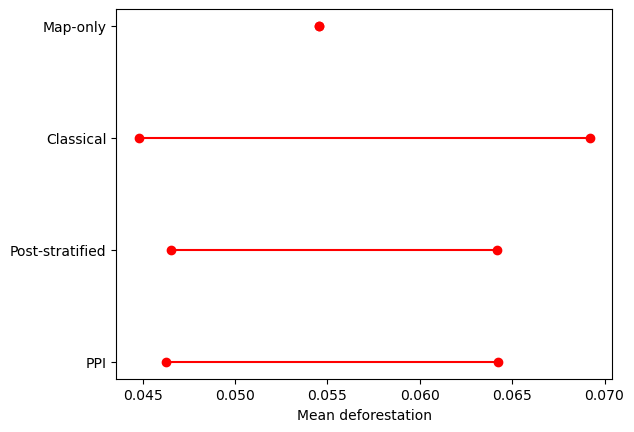

In [12]:
ppi_results = df.loc[(df['method'] == 'PPI')]
ppi_avg_estimates = ppi_results['estimate'].mean(axis=0)
ppi_avg_widths = ppi_results['width'].mean(axis=0)

post_stratified_results = df.loc[(df['method'] == 'Post-stratified')]
post_stratified_avg_estimates = post_stratified_results['estimate'].mean(axis=0)
post_stratified_avg_widths = post_stratified_results['width'].mean(axis=0)

classical_results = df.loc[(df['method'] == 'Classical')]
classical_avg_estimates = classical_results['estimate'].mean(axis=0)
classical_avg_widths = classical_results['width'].mean(axis=0)
classical_avg_widths_original = classical_avg_widths

map_only_estimates = df.loc[df['method']=='Map-only']['estimate'].mean(axis=0)
map_only_widths = df.loc[df['method']=='Map-only']['width'].mean(axis=0)

# https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python
data_dict = {}
ppi_effective_n = int(len(Y)*(classical_avg_widths/ppi_avg_widths)**2)
post_stratified_effective_n = int(len(Y)*(classical_avg_widths/post_stratified_avg_widths)**2)
data_dict['category'] = ['PPI',
                         'Post-stratified',
                         'Classical',
                         'Map-only']
data_dict['lower'] = [ppi_avg_estimates - ppi_avg_widths/2, 
                      post_stratified_avg_estimates - post_stratified_avg_widths/2, 
                      classical_avg_estimates - classical_avg_widths/2, 
                      map_only_estimates - map_only_widths/2]
data_dict['upper'] = [ppi_avg_estimates + ppi_avg_widths/2, 
                      post_stratified_avg_estimates + post_stratified_avg_widths/2, 
                      classical_avg_estimates + classical_avg_widths/2, 
                      map_only_estimates + map_only_widths/2]
data_dict['effective sample size'] = [ppi_effective_n, post_stratified_effective_n, np.nan, np.nan]
dataset = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-')
plt.yticks(range(len(dataset)),list(dataset['category']))
plt.xlabel(f'Mean deforestation')
#plt.legend() 

# Stratified mean estimation

For a fair comparison, we downsample the original stratified ground truth
dataset to match the size of the “uniformly random” dataset (n=1386). We also compute the point weights that will be used for stratified PPI.

In [13]:
strata_to_weights = {1: 0.732074512720708, # forest
                     2: 0.0677266963680275, # no forest
                     3: 0.0347025249349238, # deforestation
                     4: 0.0693684421320928, # D/ND
                     5: 0.02274148508064, # D/ND and deforestation
                     6: 0.00378489055612081, # regrowth
                     7: 0.0696014482075254} # buffer

In [14]:
# Downsample stratified dataset to 1386 points (to match destratified dataset)
data = data.reset_index(drop=True)
rand_idx = np.random.RandomState(seed=42).permutation(len(data))
downsampled_data = data.iloc[rand_idx[:1386]]

Y = np.array(downsampled_data[["Ground Truth Deforestation in 2000 to 2015"]])
Y_strata = np.array(downsampled_data["Strata_Code"])
Yhat = np.array(downsampled_data[["ML Deforestation in 2000 to 2015"]])

downsampled_data_strata_sizes = dict(downsampled_data["Strata_Code"].value_counts())
weights = np.array(downsampled_data['Strata_Code'].apply(lambda x: strata_to_weights[x]/downsampled_data_strata_sizes[x]))

ml_data_strata_sizes = dict(ml_data["strata"].value_counts())
weights_unlabeled = np.array(ml_data['strata'].apply(lambda x: strata_to_weights[x]/ml_data_strata_sizes[x]))

We compute stratified and PPI stratified 95% confidence intervals for the stratified dataset.

In [15]:
def run_ppi_stratified(Y_strata, Y, Yhat, Yhat_unlabeled, Yhat_unlabeled_stats, weights, weights_unlabeled, alpha):     
    results = []
    # Stratified Prediction-Powered Inference
    lhat = tune_lhat(Y, Yhat, Yhat_unlabeled, w=weights, w_unlabeled=weights_unlabeled)
    print("lhat =", lhat)
    stratified_ppi_ci = ppi_mean_ci_full_unlabeled_dataset(Y, Yhat, Yhat_unlabeled_stats, lhat=lhat, alpha=alpha, w=weights)

    # Stratified interval
    stratified_ci = stratified_mean_ci(strata_to_weights, Y, Y_strata, alpha=alpha)

    # Append results
    results += [
        pd.DataFrame(
            [
                {
                    "method": "PPI Stratified",
                    "n": np.nan,
                    "lower": stratified_ppi_ci[0],
                    "upper": stratified_ppi_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]
    results += [
        pd.DataFrame(
            [
                {
                    "method": "Stratified",
                    "n": np.nan,
                    "lower": stratified_ci[0],
                    "upper": stratified_ci[1],
                    "trial": 0,
                }
            ]
        )
    ]

    df = pd.concat(results, axis=0, ignore_index=True)
    df["width"] = df["upper"] - df["lower"]
    df["estimate"] = 0.5*(df["upper"] + df["lower"])
    return df

In [16]:
df = run_ppi_stratified(Y_strata, Y, Yhat, Yhat_unlabeled, Yhat_unlabeled_stats, weights, weights_unlabeled, alpha=0.05)

lhat = 0.488583944443802


Visualize the computed confidence intervals.

Text(0.5, 0, 'Mean deforestation')

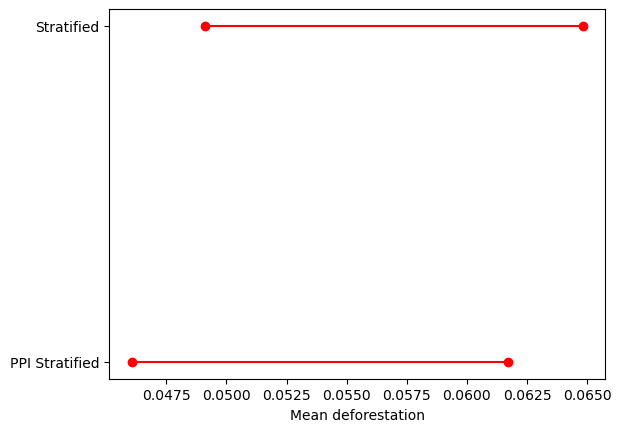

In [17]:
ppi_stratified_results = df.loc[(df['method'] == 'PPI Stratified')]
ppi_stratified_avg_estimates = ppi_stratified_results['estimate'].mean(axis=0)
ppi_stratified_avg_widths = ppi_stratified_results['width'].mean(axis=0)

stratified_results = df.loc[(df['method'] == 'Stratified')]
stratified_avg_estimates = stratified_results['estimate'].mean(axis=0)
stratified_avg_widths = stratified_results['width'].mean(axis=0)

# https://stackoverflow.com/questions/59747313/how-can-i-plot-a-confidence-interval-in-python
data_dict = {}
stratified_effective_n = int(1386*(classical_avg_widths_original/stratified_avg_widths)**2)
ppi_stratified_effective_n = int(1386*(classical_avg_widths_original/ppi_stratified_avg_widths)**2)
data_dict['category'] = [f'PPI Stratified',
                         f'Stratified']

data_dict['lower'] = [ppi_stratified_avg_estimates - ppi_stratified_avg_widths/2, stratified_avg_estimates - stratified_avg_widths/2]
data_dict['upper'] = [ppi_stratified_avg_estimates + ppi_stratified_avg_widths/2, stratified_avg_estimates + stratified_avg_widths/2]
data_dict['effective sample size'] = [ppi_stratified_effective_n, stratified_effective_n]
dataset2 = pd.DataFrame(data_dict)

for lower,upper,y in zip(dataset2['lower'],dataset2['upper'],range(len(dataset2))):
    plt.plot((lower,upper),(y,y),'ro-')
plt.yticks(range(len(dataset2)),list(dataset2['category']))
plt.xlabel(f'Mean deforestation')
#plt.legend()

# Visualize all results in one figure

In [18]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

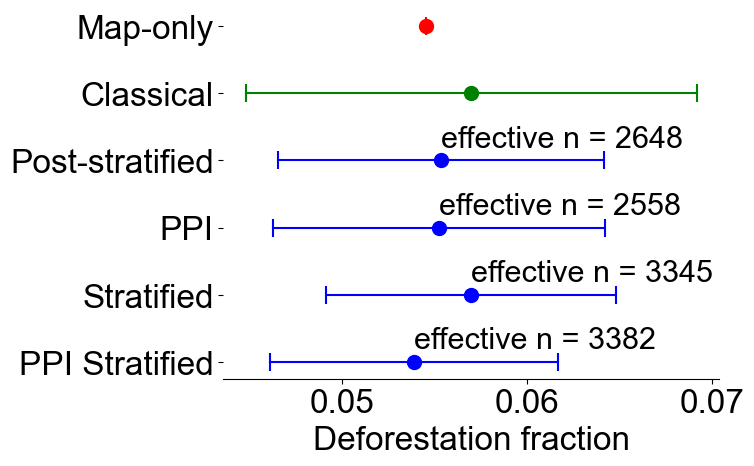

In [19]:
dataset_final = pd.concat([dataset2, dataset])
colors = ['blue', 'blue', 'blue', 'blue', 'green', 'red']

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for lower,upper,effective_n,y in zip(dataset_final['lower'],dataset_final['upper'],dataset_final['effective sample size'], range(len(dataset_final))):
        plt.scatter([(lower+upper)/2], [y], color=colors[y], s=100)
        plt.scatter([lower, upper], [y, y], color=colors[y], marker='|', s=150)
        plt.plot((lower,upper),(y,y),color=colors[y])
        if y in [0, 1, 2, 3]:
            plt.text((lower+upper)/2, (y+0.2), f'effective n = {int(effective_n)}', fontsize = 22)
        plt.yticks(np.arange(len(dataset_final)),list(dataset_final['category']))
        
plt.xlabel(f'Deforestation fraction')
plt.savefig(f'output_images/deforestation_mean.png', dpi=300, bbox_inches='tight')
plt.show()